### Homework 6
#### Implementing a neural network

In this homework we will implement a feedforward sigmoidal neural network with $\tanh$ as an activation function "from the book".

It will help to have with you the supplemental book chapter on neural nets, particularly the part on back-propagation.



In [80]:
import numpy as np
def init_nn(D_l,sigma=1):
    """
    Initialize Artificial Neural Network
    Input:  Numpy array D_l is a list of layer sizes from 0 to L of an ANN
    Output: A python list of weight matrixes W(l) for l = 1..L (inclusive)
    The weight matrixes are numpy 2d arrays and are initialized from the standard
    normal distribution.
    """
    np.random.seed(22)
    L = D_l.shape[0]-1
    w = []

    for l in range(1,L+1):
        d_prev = D_l[l-1]
        d_l = D_l[l]
        W_l = np.random.randn((d_prev+1)*d_l).reshape((d_prev+1),d_l)
        W_l = W_l*sigma #we want _small_ initial weights: sigma*max(norm(x)) << 1
        w.append(W_l)
    return w

### Optional -- Use Xavier initialization, sigma = 4*sqrt(2/(n_inputs+n_outputs))

def forward_prop(x,w,regression = False):
    """
    Input: 
        d+1 dimensional input vector x to the neural network;
        length L-1 list w of weight matrixes
        optional threshold (activation) function theta
    Output:
        An array xx of intermediate layer output values, l=0,...,L
        An array s of intermediate layer input values, l=1,...,L
    To be consistent with the indexing from the book, s begins with a
    placeholder 0.  Please ignore this value.  (Notice that s is never
    actually used in the code, and in an optimized implementation we 
    would not even compute it directly.)
    """
    theta=np.tanh
    assert(x[0]==1) #x should have the bias node
    assert(len(x) == w[0].shape[0] ) #make sure the sizes match

    xx = []
    s = [0]  # initial zero used only to simplify indexing
    xx.append(x)
    l=1

    for W in w[:-1]:
        s.append(W.transpose().dot(xx[-1]))## Update s
        xx.append(np.hstack((np.array([1]),theta(s[1]))))## Update xx
        l += 1
    W = w[-1]
    ## Update last s (special case)
    s.append(W.transpose().dot(xx[-1]))
    if regression:
        xx.append(s[1])## Update last xx (special case)
    else: #classification
        xx.append(theta(s[1]))## Update last xx (special case)
    return xx,s

def back_prop(xx,w,yi,regression=False):
    assert(np.isscalar(yi)) # yi is just the y value for the instance x
    delta = []
    L = len(w)
    if regression:
        ## Initialize delta
        delta.append((2*(xx[L]-yi))*1) #delta_L, assume theta = id
    else: #classification
        ## Initialize delta
        delta.append(2*((xx[L]-yi))*(1-(xx[L]**2))) #delta_L, assume theta = tanh
    l = L-1
    for W in reversed(w[1:]):
        thetaprime = (1-(xx[1]))[1:] ##?? Update this
        delta_lp1 = delta[-1]  ## delta from l+1 layer
        delta_l = thetaprime*W.dot(delta[-1])[1:]##?? Update this, delta from layer l
        delta.append(delta_l)
        l -= 1
    return list(reversed(delta))

def nn_gradient(xx,delta):
    grad = []
    L = len(xx)-1
    for x,d in zip(xx[:-1],delta):
        _x = x.reshape(x.shape[0],1)
        _d = d.reshape(d.shape[0],1)
        grad.append(_x.dot(_d))# Update this)
    return grad

def nn_stoch_grad_des(X,y,D_l,eta=0.01,iterations=1000,regression = False,sigma=1):
    np.random.seed(100)
    w = init_nn(D_l,sigma)
    for _iterations in range(iterations):
        r = np.random.randint(X.shape[0])
        x = X[r]
        yi = y[r]
        xx,s = forward_prop(x,w,regression)
        delta = back_prop(xx,w,yi,regression)
        grad = nn_gradient(xx,delta)
        new_w = []
        for wi,w_g in zip(w,grad):
            new_w.append(wi - eta*w_g)
        w = new_w
    return w

def nn_predict(x,w,regression=False):
    xx,s = forward_prop(x,w,regression)
    if not regression: #classification
        return np.sign(xx[-1])
    else:
        return xx[-1]


def nn_predict_all(X,w,regression=False):
    g = np.ones(X.shape[0])
    for i,x in enumerate(X):
        g[i] = nn_predict(x,w,regression)
    return g



### Part 1: Initialize the network 

The first task is to build the weight matrices from a description of the network.  As you can see from the docstring, `init_nn(D_l,sigma=1)` takes as input a numpy array of layer sizes `D_l` which is the "architecture" of the net.  It also takes a parameter $\sigma$ which controls how close the initial weight vector is to the origin.  

What we want to do is return a python list object `w` which represents

$$\bar{w} = [W^{(1)},W^{(2)},\ldots,W^{(L)}].$$

Note that $L$ can be derived from the length of `D_l`.  The matrices $W^{(l)}$ will be numpy matrices initialized with numbers sampled from the standard normal distribution (so use `np.random.randn`).  Each number needs to be divided by $\sigma$ which can be done as one broadcast operation `W = W/sigma`. 

Throughout this assignment the worked Example 7.1 from the supplementary book chapter will be very helpful.  

To initialize that network with random weights we would do the following.



In [81]:
w = init_nn(np.array([1,2,1,1]))
w

[array([[-0.09194992, -1.46335065],
        [ 1.08179168, -0.23932517]]),
 array([[-0.49112914],
        [-1.00227201],
        [ 0.9188215 ]]),
 array([[-1.1036321 ],
        [ 0.62649346]])]

Notice that I have set the random number seed at 22 so that we all get the same results.  But in a working network you would want to use real random number for the weights so that you don't always start at the same initial weight vector (which might be a bad spot in the weight space).


### Part 2: Forward propagation

We will now implement the forward propagation part of the neural network algorithm.

This process is needed for back-propagation, but it is also how you "run" the network after you have trained it.  

As described in the docstring, the method should return `xx` which is what the book denotes as 

$${\bf{x}}^{(\mathcal{l})} \text{ for } \mathcal{l} = 0,\ldots,L$$

It also returns `s` which is what the book calls 


$${\bf{s}}^{(\mathcal{l})} \text{ for } \mathcal{l} = 1,\ldots,L$$

Because array indexing doesn't start at 1 in python I have initialized `s` to contain a placeholder 0.  This is just so that you can use the same index notation as used in the book, for example

$${\bf{s}}^{(l)} = (W^{(l)})^Tx^{(l-1)}$$

when you write your code.

If you follow the forward propagation pseudocode from the book be sure to adjust it so that you do $l=L$ as a special case.  In particular you do not want ${\bf{x}}^{(L)}$ to have a bias node.  You also want to do different things depending on the truth value of the `regression` function parameter. This parameter is `True` if the user intends to use the network for regression (in which case the final activation function is not applied and ${\bf{x}}^{(L)}={\bf{s}}^{(L)}$). For classification (when `regression` is `False`) ${\bf{x}}^{(L)}=\theta({\bf{s}}^{(L)})$.


In [82]:
print("Testing based on Example 7.1 from the book..")
regression = False
w = init_nn(np.array([1,2,1,1]))
shapes = list(map(np.shape,w))
print("w shapes:", shapes)
w[0] = np.array([0.1,2]).reshape((2,1))
w[1] = np.array([0.1,.2]).reshape((2,1))
w[2] = np.array([0.5,0.5]).reshape((2,1))
newshapes = list(map(np.shape,w))
#assert(shapes==newshapes)
print("w:",w)

x = np.array([1,2])
xx,s =forward_prop(x,w,regression)
print("xx:",xx)
print("s:",s)


Testing based on Example 7.1 from the book..
w shapes: [(2, 2), (3, 1), (2, 1)]
w: [array([[0.1],
       [2. ]]), array([[0.1],
       [0.2]]), array([[0.5],
       [0.5]])]
xx: [array([1, 2]), array([1.        , 0.99945084]), array([1.        , 0.99945084]), array([0.99945084])]
s: [0, array([4.1]), array([0.29989017]), array([0.99972542])]


In [83]:
np.tanh(0.706)

0.608162409002161

### Part 3: Back-propagation

The reason back-propagation works to give $\nabla e$ is kind of hard to understand, but the method itself isn't too hard to implement. The pseudocode in the book will guide you. Notice that the initialization of ${\bf{\delta}}^{(L)}$ depends on whether you're doing regression or classification.  You should put an `if` statement in your code that checks the truth value of `regression` and make the appropriate initialization. Also notice that ${\bf{\delta}}^{(0)}$ is not used, so please don't compute it.  Compare the output of the test case below to Example 7.1 in the book to see the exact form of `delta` the code should return. 


In [84]:
print("Testing based on Example 7.1 from the book..")
regression = False
w = init_nn(np.array([1,2,1,1]))
shapes = list(map(np.shape,w))
print("w shapes:", shapes)
w[0] = np.array([0.1,2]).reshape((2,1))
w[1] = np.array([0.1,.2]).reshape((2,1))
w[2] = np.array([0.5,0.5]).reshape((2,1))
newshapes = list(map(np.shape,w))
#assert(shapes==newshapes)
print("w:",w)

x = np.array([1,2])
xx,s =forward_prop(x,w,regression)
print("xx:",xx)
print("s:",s)

delta = back_prop(xx,w,1,regression)
print("delta:",delta)


Testing based on Example 7.1 from the book..
w shapes: [(2, 2), (3, 1), (2, 1)]
w: [array([[0.1],
       [2. ]]), array([[0.1],
       [0.2]]), array([[0.5],
       [0.5]])]
xx: [array([1, 2]), array([1.        , 0.99945084]), array([1.        , 0.99945084]), array([0.99945084])]
s: [0, array([4.1]), array([0.29989017]), array([0.99972542])]
delta: [array([-3.63684378e-14]), array([-3.31130108e-10]), array([-1.2059594e-06])]


In [85]:
(1-0.99999**2)*-0.44

-8.79995599995631e-06

### Part 4: The gradient of ${\bf{e}}$

We now fill in the code for `nn_gradient(xx,delta)`.  This function takes `xx` = $[{\bf{x}}^{(0)},{\bf{x}}^{(1)},\ldots,{\bf{x}}^{(L)},]$ and `delta` = $[{\bf{\delta}}^{(1)},{\bf{\delta}}^{(2)},\ldots,{\bf{\delta}}^{(L)},]$ as input.  It then returns `grad` = $[\frac{\partial {\bf{e}}}{\partial W^{(1)}},\frac{\partial {\bf{e}}}{\partial W^{(2)}},\ldots,\frac{\partial {\bf{e}}}{\partial W^{(L)}}]$. The return vector `grad` is computed by using the formula
$$\frac{\partial {\bf{e}}}{\partial W^{(l)}} = {\bf{x}}^{(l-1)}({\bf{\delta}}^{(l)})^T.$$

Notice that ${\bf{x}}^{(L)}$ is never used. 

We can now do the complete test based on Example 7.1 from the book.

In [86]:
print("Testing based on Example 7.1 from the book..")
regression = False
w = init_nn(np.array([1,2,1,1]))
shapes = list(map(np.shape,w))
print("w shapes:", shapes)
w[0] = np.array([0.1,2]).reshape((2,1))
w[1] = np.array([0.1,.2]).reshape((2,1))
w[2] = np.array([0.5,0.5]).reshape((2,1))
newshapes = list(map(np.shape,w))
#assert(shapes==newshapes)
print("w:",w)

x = np.array([1,2])
xx,s =forward_prop(x,w,regression)
print("xx:",xx)
print("s:",s)

delta = back_prop(xx,w,1,regression)
print("delta:",delta)
wg = nn_gradient(xx,delta)
print("gradient:",wg)

Testing based on Example 7.1 from the book..
w shapes: [(2, 2), (3, 1), (2, 1)]
w: [array([[0.1],
       [2. ]]), array([[0.1],
       [0.2]]), array([[0.5],
       [0.5]])]
xx: [array([1, 2]), array([1.        , 0.99945084]), array([1.        , 0.99945084]), array([0.99945084])]
s: [0, array([4.1]), array([0.29989017]), array([0.99972542])]
delta: [array([-3.63684378e-14]), array([-3.31130108e-10]), array([-1.2059594e-06])]
gradient: [array([[-3.63684378e-14],
       [-7.27368757e-14]]), array([[-3.31130108e-10],
       [-3.30948266e-10]]), array([[-1.20595940e-06],
       [-1.20529714e-06]])]


### Test drive

I already implemented SGD for you so at this point your NN should be ready to run.  Let's play with it by trying to classify the cancer data into "benign" or "malignant".

First we load the scaling function (scaling is hugely important for NNs) and the data.


In [87]:
def scaler(X_train,X_test):
    assert(X_train.shape[1]==X_test.shape[1])
    sigma = np.std(X_train,axis=0)
    zeros = np.isclose(sigma,np.zeros(sigma.shape[0]))
    sigma[zeros] = 1

    mu = np.mean(X_train,axis=0)
    mu[0] = 0
    X_train = (X_train-mu)/sigma
    X_test = (X_test-mu)/sigma
    return X_train,X_test    

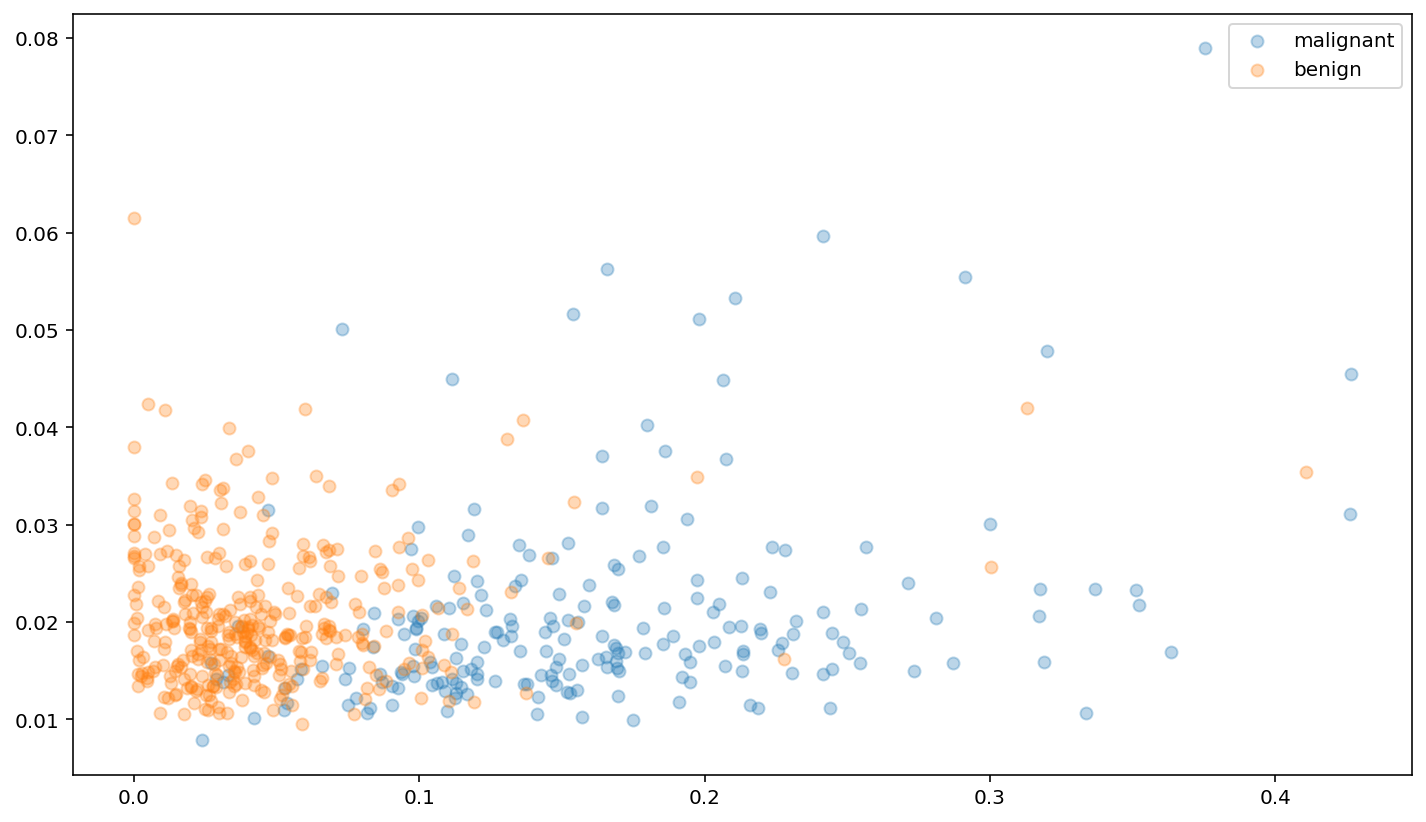

In [88]:
import matplotlib.pyplot as plt

D = np.loadtxt(open("num_data.txt", "rb"), delimiter=",", skiprows=0)


x  = D[:,8]
y  = D[:,20]

malignant = D[:,1]==1  ## Column 1 represents benign (0) or malignant (1)
xm = x[malignant]
ym = y[malignant]

benign = D[:,1]==0
xb = x[benign]
yb = y[benign]

plt.scatter(xm,ym,label="malignant",alpha=0.3)
plt.scatter(xb,yb,label="benign",alpha=0.3)

plt.legend()
plt.show()


In the code below I train the NN on the above 2D data and compute the training error.

Can you improve the training error by adjusting $\eta$, the architecture, or the number of iterations?

In [90]:
X = np.ones(D.shape[0]*3).reshape(D.shape[0],3)
X[:,1] = D[:,20]
X[:,2] = D[:,8]
X,X = scaler(X,X)

y = 2*malignant -1  # so that y in {-1,1}, not {0,1}

regression = False
D_l = np.array([2,3,2,1,1,2,1]) #architecture
w = nn_stoch_grad_des(X,y,D_l,eta = .01,iterations = 2000,regression=regression)
g = nn_predict_all(X,w,regression)
print(np.mean(np.sign(g) != y))


ValueError: shapes (1,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

NameError: name 'g' is not defined

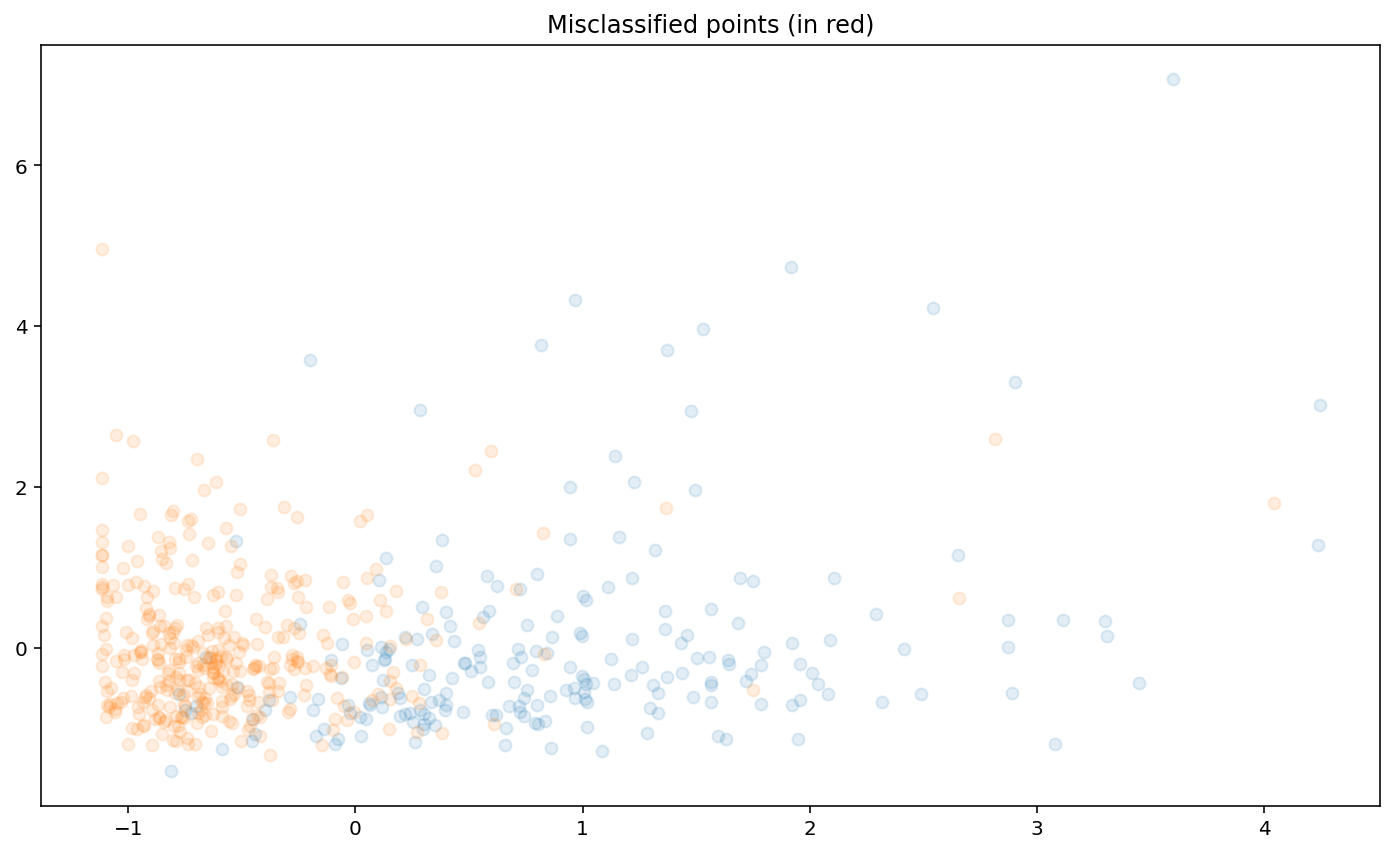

In [91]:
xm = X[:,2][malignant]
ym = X[:,1][malignant]

xb = X[:,2][benign]
yb = X[:,1][benign]


plt.scatter(xm,ym,label="malignant",alpha=0.13)
plt.scatter(xb,yb,label="benign",alpha=0.13)
plt.title("Misclassified points (in red)")
plt.scatter(X[g!=y][:,2],X[g!=y][:,1],c='red',alpha=0.2)
plt.show()
plt.title("All points with correct classification")
plt.scatter(xm,ym,label="malignant",alpha=0.13)
plt.scatter(xb,yb,label="benign",alpha=0.13)

plt.show()
num = 100
xc = np.linspace(-1,4,num)
yc = np.linspace(-1,6,num)
cart_prod = np.transpose([np.tile(xc, len(yc)), np.repeat(yc, len(xc))])
Xc = np.c_[np.ones(len(cart_prod)),cart_prod[:,1],cart_prod[:,0]]

X,Xc = scaler(X,Xc)
gc = nn_predict_all(Xc,w,regression)
says_yeah = gc == 1
says_no = ~says_yeah


plt.title("Decision boundary of NN")
plt.scatter(xm,ym,label="malignant",alpha=0.43)
plt.scatter(xb,yb,label="benign",alpha=0.43)
plt.scatter(cart_prod[says_yeah][:,0],cart_prod[says_yeah][:,1],label="predict yes",alpha=0.05,color='g')
plt.scatter(cart_prod[says_no][:,0],cart_prod[says_no][:,1],label="predict no",alpha=0.05,color='r')

plt.legend()
plt.show()



The above was just using 2 of the 30 independent variables.

Let's try it with 3. 



In [94]:
X = np.ones(D.shape[0]*4).reshape(D.shape[0],4)
X[:,1] = D[:,8]
X[:,2] = D[:,20]
X[:,3] = D[:,15]
X,X = scaler(X,X)
y = 2*malignant -1  # so that y in {-1,1}, not {0,1}

D_l = np.array([3,4,2,1])
w = nn_stoch_grad_des(X,y,D_l,iterations = 1000)
g = nn_predict_all(X,w)
np.mean(g != y)

ValueError: shapes (1,3) and (5,) not aligned: 3 (dim 1) != 5 (dim 0)

Now let's try it with all the data. 

Can you improve on this training error? 


In [95]:
X = np.ones((D.shape[0],(D.shape[1]-2)+1))
X[:,1:] = D[:,2:]
X,X = scaler(X,X)

y = 2*D[:,1] -1  # so that y in {-1,1}, not {0,1}

D_l = np.array([X.shape[1]-1,5,2,1])
w = nn_stoch_grad_des(X,y,D_l,iterations = 10000)
g = nn_predict_all(X,w)
np.mean(g != y)

ValueError: shapes (1,3) and (6,) not aligned: 3 (dim 1) != 6 (dim 0)

#### Sanity check...

Let's make sure that the `sklearn` neural network with the same settings is performing more or less like the one we wrote...

The `sklearn` `score` function gives accuracy rather than error.

So subtract the `sklearn` score from 1 to get the error.  

Notice that with `sklearn` you don't tell it the number of nodes in layer 0 or $L$.  That's because $d^{(L)}$ must be 1 for classification, and $d^{(0)}$ is implicit from X.  


In [96]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='sgd', alpha=0,hidden_layer_sizes=(5,2), random_state=1,activation='tanh',max_iter=10000, learning_rate='constant', learning_rate_init=0.01)

clf.fit(X, y)   
1-clf.score(X,y)

0.007029876977152849

### Nonlinear boundary

In class we talked about the "universal approximation theorem" which says that a neural network with 2 hidden layers can learn any decision boundary (approximately).  Let's give the NN some data that is not at all linearly separable and see what it comes up with. 


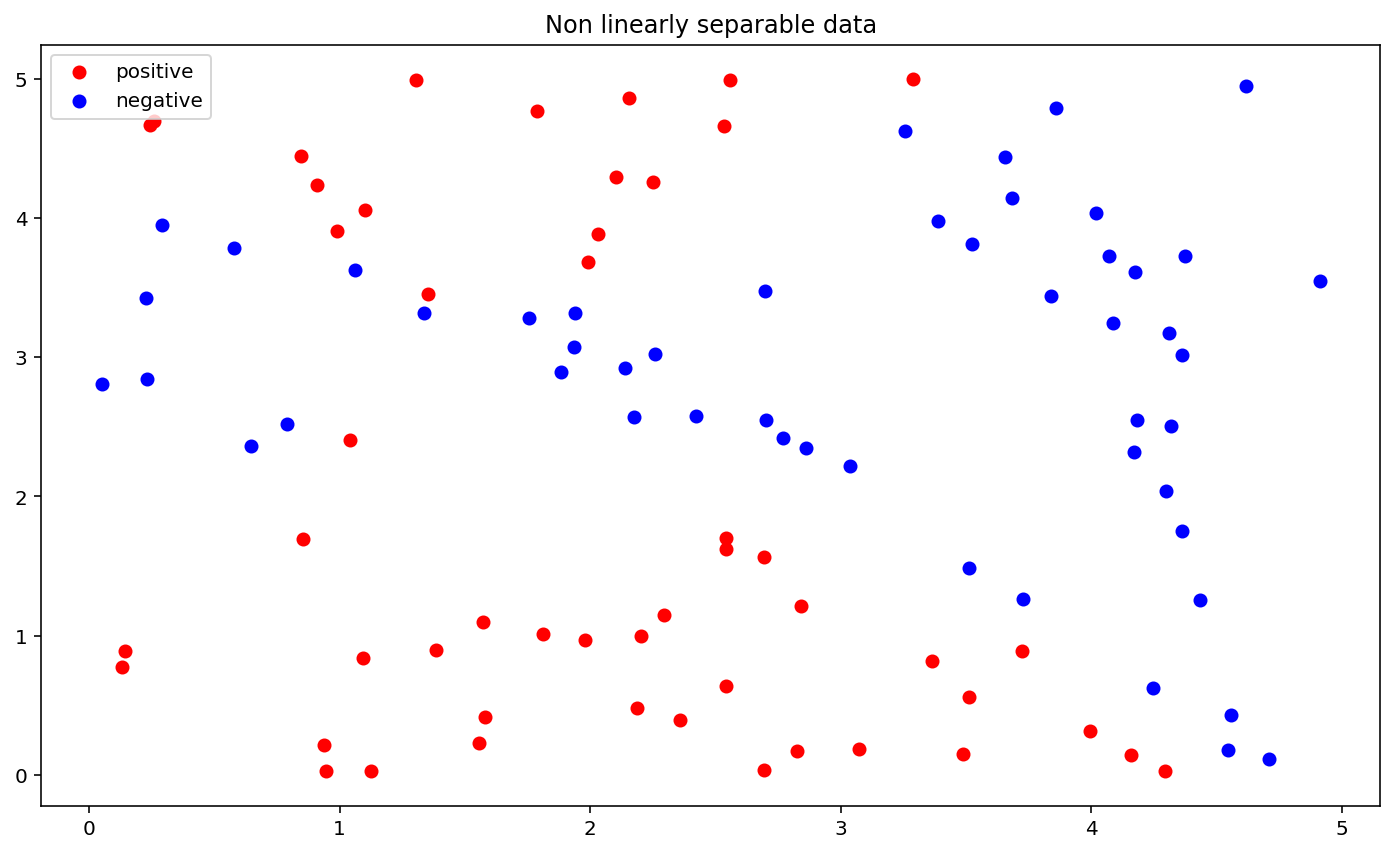

In [97]:
np.random.seed(22)
N=100
pts = np.random.rand(2*N).reshape(N,2)*5
X = np.ones((N,3))
X[:,1] = pts[:,0]
X[:,2] = pts[:,1]

f = lambda x: np.sin(x[1])+np.cos(x[2])

R = np.apply_along_axis(f,1,X)

pos = R > 0
neg = ~pos

y = 2*pos-1

plt.scatter(X[pos,1],X[pos,2],color="red",label="positive")
plt.scatter(X[neg,1],X[neg,2],color="blue",label="negative")
plt.title("Non linearly separable data")
plt.legend()
plt.show()

In [98]:
D_l = np.array([X.shape[1]-1,6,1])
X2,X2 = scaler(X,X)
w = nn_stoch_grad_des(X2,y,D_l,eta=0.01,iterations = 10000)
g = nn_predict_all(X2,w)
np.mean(g != y)

ValueError: shapes (7,1) and (6,) not aligned: 1 (dim 1) != 6 (dim 0)

In [99]:
clf.fit(X, y)   
1-clf.score(X,y)

0.030000000000000027

In [100]:
num = 100
xc = np.linspace(0,5,num)
yc = np.linspace(0,5,num)
cart_prod = np.transpose([np.tile(xc, len(yc)), np.repeat(yc, len(xc))])
Xc = np.c_[np.ones(len(cart_prod)),cart_prod[:,1],cart_prod[:,0]]

X_u = np.ones((N,3))
X_u[:,1] = pts[:,0]
X_u[:,2] = pts[:,1]

A,Xc = scaler(X_u,Xc)
gc = nn_predict_all(Xc,w,regression)
says_yeah = gc == 1
says_no = ~says_yeah

plt.title("Decision boundary of NN")

plt.scatter(Xc[says_yeah][:,1],Xc[says_yeah][:,2],alpha=0.05,color='g')
plt.scatter(Xc[says_no][:,1],Xc[says_no][:,2],alpha=0.05,color='r')
plt.scatter(A[y==1][:,1],A[y==1][:,2],label="1",alpha=0.43,c='b')
plt.scatter(A[y!=1][:,1],A[y!=1][:,2],label="-1",alpha=0.43,c='white')
plt.legend()
plt.show()

AssertionError: 

### Regression

Let's try to make it do regression...



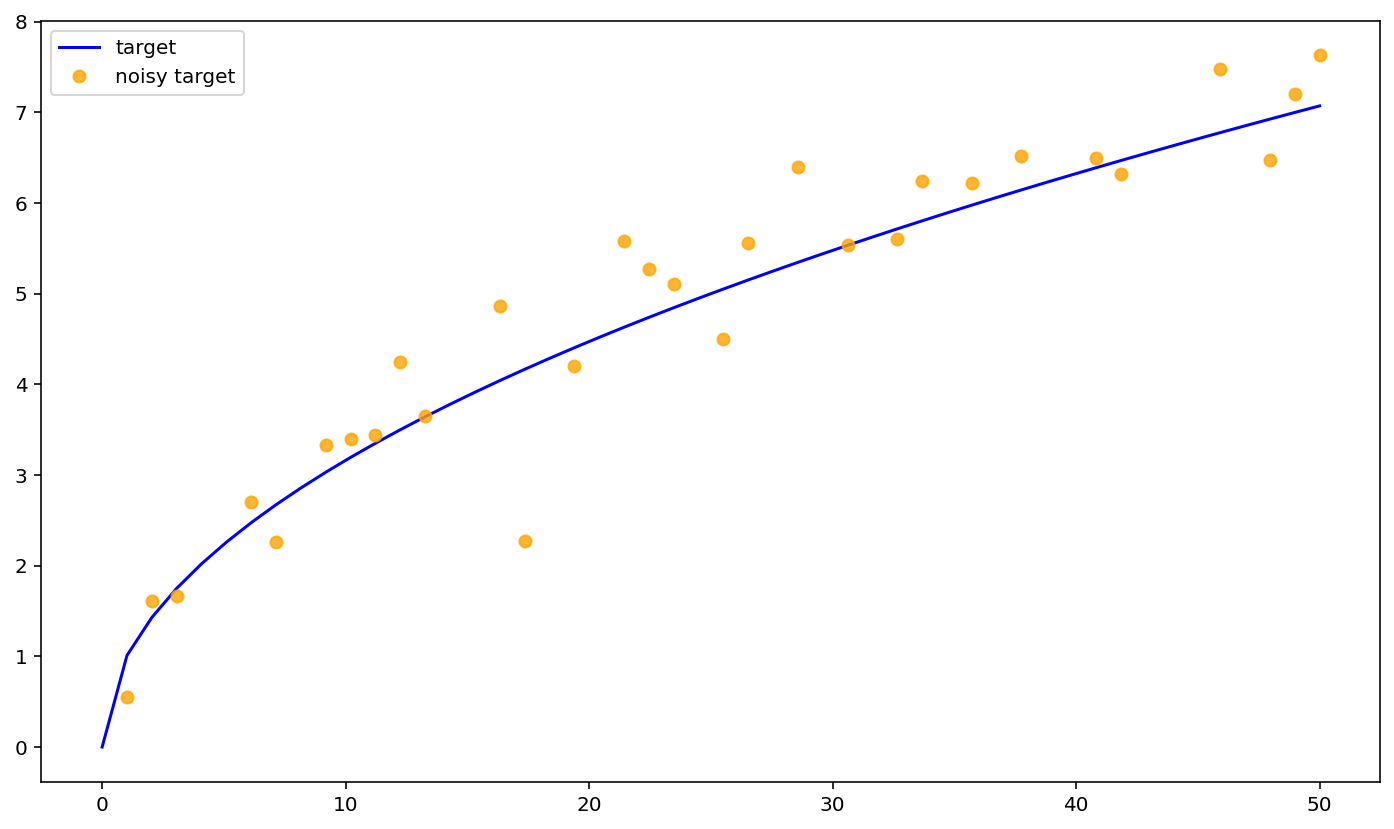

In [92]:
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(0,50,50) ## The domain
N = 30   ## 30 sample points
np.random.seed(22)  # so we get the same random stuff
shuff = np.random.permutation(len(x))
x_pts = sorted(x[shuff][:N])  ## Pick N points at random from the domain

f = np.sqrt   #The target function (no noise yet)

sigma = 1/2
noise = np.random.randn(N)*sigma  ## Noise sampled from the normal distribution with sd=sigma

f_noisy = f(x_pts) + noise   ## Noisy data

plt.plot(x,f(x),label="target",c='blue')
plt.plot(x_pts,f_noisy,'o',label="noisy target",alpha=0.8,c='orange')
plt.legend()
plt.show()

In [101]:
def MAE(g,y):
    """g is the predicted outcomes and y is the actual outcomes"""
    return np.mean(np.abs(g-y))

def RMSE(g,y):
    """g is the predicted outcomes and y is the actual outcomes"""
    return np.sqrt(np.mean((g-y)**2))
    
def R2(g,y):
    """g is the predicted outcomes and y is the actual outcomes"""
    mu = np.mean(y)
    SStot = np.sum((y-mu)**2)
    SSres = np.sum((g-y)**2)
    return 1-SSres/SStot
    
X = np.ones(N*2).reshape(N,2)
X[:,1] = x_pts
X,X = scaler(X,X)

y = f_noisy

D_l = np.array([X.shape[1]-1,3,3,1])


w = nn_stoch_grad_des(X,y,D_l,eta=0.001,iterations = 10000,regression=True,sigma=1)
g = nn_predict_all(X,w,regression=True)


plt.plot(x_pts,g,label="regression line",c='red')
plt.plot(x,f(x),label="target",c='blue')
plt.plot(x_pts,f_noisy,'o',label="noisy target",alpha=0.8,c='orange')
plt.title(f"MAE = {MAE(g,y):0.3}, RMSE = {RMSE(g,y):0.3}, R2={R2(g,y):0.3}")

plt.legend()

plt.show()

ValueError: cannot copy sequence with size 30 to array axis with dimension 100

### Part 5: Overfitting

Below I'm training and testing on the full breast cancer dataset.

But I'm overfitting.  Adjust the architecture and other settings so that overfitting isn't taking place.

Try to get the lowest possible test error.


In [102]:
def test_train_split(X,y,train_percent=0.8,rand_seed=42):
    np.random.seed(rand_seed)
    cutoff = int(train_percent*X.shape[0])
    shuff = np.random.permutation(X.shape[0])
    X2 = X[shuff]
    y2 = y[shuff]
    X_train = X2[:cutoff]
    X_test = X2[cutoff:]
    y_train = y2[:cutoff]
    y_test = y2[cutoff:]
    return X_train,X_test,y_train,y_test
    
    
D = np.loadtxt(open("num_data.txt", "rb"), delimiter=",", skiprows=0)
X = np.ones((D.shape[0],(D.shape[1]-2)+1))
X[:,1:] = D[:,2:]
y = 2*D[:,1] -1  # so that y in {-1,1}, not {0,1}

X_train,X_test,y_train,y_test = test_train_split(X,y)
X_train,X_test = scaler(X_train,X_test)


D_l = np.array([X.shape[1]-1,15,5,1])
w = nn_stoch_grad_des(X_train,y_train,D_l,iterations = 10000)

print("Training Error")
g = nn_predict_all(X_train,w)
print(np.mean(g != y_train))


print("Test Error")
g = nn_predict_all(X_test,w)
print(np.mean(g != y_test))

ValueError: shapes (1,6) and (16,) not aligned: 6 (dim 1) != 16 (dim 0)